In [12]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

In [13]:
node_size = 300
font_size = 13
width = 5

In [14]:
init = 'initial'
final = 'final'
label = 'label'
in_encoding = 'in_encoding'
in_current = 'in_current'
children = 'children'
init_count = 'init_count'
final_count = 'final_count'

In [38]:
def plot_encoding_tree(t, transition=None, title=None, plot_encoding=False):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    if title: 
        plt.title(title)
    plt.axis('off')
    pos = graphviz_layout(t, prog='dot')
    if plot_encoding:
        nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][in_encoding]], 
                           node_size=node_size*2, node_color='white',linewidths=width, edgecolors='m')
    else:
        # plot the complement
        nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if not t.nodes[u][in_current]], 
                           node_size=node_size*2, node_color='white',linewidths=width, edgecolors='c')
    nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][in_current]], 
                           node_size=node_size*1.2, node_color='white',linewidths=width, edgecolors='g')
    nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][label]==init], 
                           node_size=node_size, node_color='b', alpha=1)
    nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][label]==final], 
                           node_size=node_size, node_color='r', alpha=1)
    nx.draw_networkx_labels(t, pos, font_size=font_size)
    nx.draw_networkx_edges(t, pos, width=1.5)
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    nodes = [u for u in t if t.nodes[u][in_encoding] or t.nodes[u][in_current]]
    ct = nx.induced_subgraph(t, nodes)
    nx.draw_networkx_nodes(ct, pos, nodelist=[u for u in t if t.nodes[u][in_encoding]], 
                           node_size=node_size*2, node_color='white',linewidths=width, edgecolors='m')
    nx.draw_networkx_nodes(ct, pos, nodelist=[u for u in t if t.nodes[u][in_current]], 
                           node_size=node_size*1.2, node_color='white',linewidths=width, edgecolors='g')
    nx.draw_networkx_labels(ct, pos, font_size=font_size)
    nx.draw_networkx_edges(ct, pos, width=1.5)

In [39]:
def count(t, root):
    t.nodes[root][init_count] = t.nodes[root][label] == init
    t.nodes[root][final_count] = 1 - t.nodes[root][init_count]
    if t.out_degree(root) == 0:
        t.nodes[root][children] = []
    else:
        for u in t.successors(root):
            count(t, u)
            t.nodes[root][init_count] += t.nodes[u][init_count]
            t.nodes[root][final_count] += t.nodes[u][final_count]

def color_the_tree(t, root, color):
    t.nodes[root][label] = init if color == 0 else final
    for u in t.successors(root):
        color_the_tree(t, u, 1-color)


def get_blue_leaves(t, root, leaf_list):
    if t.out_degree(root) == 0 and t.nodes[root][label] == init:
        leaf_list.append(root)
        return
    for u in t.nodes[root][children]:
        get_blue_leaves(t, u, leaf_list)


def build_dfs_order(t, root):
    if t.out_degree(root) == 0:
        t.nodes[root][children] = []
        return
    t.nodes[root][children] = sorted([u for u in t.successors(root)],
                            key=lambda u: t.nodes[u][init_count]-t.nodes[u][final_count])
    for u in t.nodes[root][children]:
        build_dfs_order(t, u)

def generate_tree(n):
    t = nx.random_tree(n)
    root = random.sample(t.nodes, 1)[0]
    t = nx.dfs_tree(t, root)
    color_the_tree(t, root, random.choice([0, 1]))
    count(t, root)
    num_init, num_final = t.nodes[root][init_count], t.nodes[root][final_count]
    if num_init != num_final:
        target_label = init if num_init < num_final else final
        candidates = [u for u in t if t.nodes[u][label] != target_label]
        for idx in range(len(t), len(t) + abs(num_init-num_final)):
            u = random.choice(candidates)
            t.add_edge(u, idx)
            t.nodes[idx][label] = target_label
        count(t, root)
    for u in t:
        t.nodes[u][in_current] = t.nodes[u][label] == init
        t.nodes[u][in_encoding] = t.nodes[u][label] != init
    build_dfs_order(t, root)
    dfs_order = []
    dfs_string(t, root, res=dfs_order)
    g = nx.OrderedDiGraph()
    g.add_nodes_from(dfs_order)
    g.add_edges_from(t.edges)
    for u in t:
        g.nodes[u][in_current] = t.nodes[u][in_current]
        g.nodes[u][in_encoding] = t.nodes[u][in_encoding]
        g.nodes[u][children] = t.nodes[u][children]
        g.nodes[u][label] = t.nodes[u][label]
    to_borrow = []
    get_blue_leaves(g, root, to_borrow)
    return g, root, to_borrow, [], dfs_order


def get_parent(t, u):
    pre = list(t.predecessors(u))
    return pre[0] if len(pre) > 0 else None


def dfs_string(t, root, res):
    res.append(root)
    for u in t.nodes[root][children]:
        dfs_string(t, u, res)

def get_neighbors_of_status(t, root, status):
    parent = get_parent(t, root)
    neighbors_of_status = [parent] if parent is not None and t.nodes[parent][status] else []
    neighbors_of_status.extend([u for u in t.nodes[root][children] if t.nodes[u][status]])
    return neighbors_of_status

In [40]:
def update_encoding_for_blue(t, blue, pre_reds):
    # the idea is to add blue in the encoding while it can be.
    if t.nodes[blue][in_current] or t.nodes[blue][in_encoding]:
        return
    neighbors_in_encoding = get_neighbors_of_status(t, blue, in_encoding)
    n = len(neighbors_in_encoding)
    red = -1
    if n == 0:
        assert len(pre_reds) > 0
        red = pre_reds.pop()
    elif n == 1:
        red = neighbors_in_encoding[0]
    if red != -1 and t.nodes[red][in_encoding] and t.nodes[red][in_current]:
        # the red vertex need to be both purple and green!.
        # we can drag from red to blue:
        t.nodes[red][in_encoding] = False
        t.nodes[blue][in_encoding] = True
        plot_encoding_tree(t, title=f"move encoding: {red} -> {blue}, reds: {pre_reds}")
        update_encoding_for_red(t, red, pre_reds)

def update_encoding_for_red(t, red, pre_reds):
    # this red has been released, check if one of its neighbors can be purple now
    # notice that that neighbor must be "not in current" and "not in encoding"
    if t.nodes[red][in_encoding]:
        return
    # the red is finished now! no purple circle around, and green is around.
    parent = get_parent(t, red)
    neighbors = [parent] if parent is not None else []
    neighbors.extend(t.nodes[red][children])
    for blue in neighbors:
        # consider blue
        if not t.nodes[blue][in_encoding]:
            update_encoding_for_blue(t, blue, pre_reds)

In [41]:
def drag_green_to_parent(t, blue, pre_reds, update_encoding=False):
    # should consider both leaf and non-leaf cases.
    parent = get_parent(t, blue)
    if parent is None or not t.nodes[blue][in_current]:
        return False
    neighbors_of_parent_in_current = get_neighbors_of_status(t, parent, in_current)
    if len(neighbors_of_parent_in_current) > 1:
        return False
    t.nodes[blue][in_current] = False
    t.nodes[parent][in_current] = True
    plot_encoding_tree(t, title=f"to parent: {blue} -> {parent}, reds: {pre_reds}")
    # on the fly
    update_encoding_for_blue(t, blue, pre_reds)

In [42]:
def drag_green_from_parent(t, red, pre_reds):
    parent = get_parent(t, red)
    if parent is None or not t.nodes[parent][in_current]:
        return False
    neighbors_in_current = get_neighbors_of_status(t, red, in_current)
    # the parent is the only vertex in the independent set.
    assert len(neighbors_in_current) == 1 and neighbors_in_current[0] == parent
    # is this true?
    assert t.nodes[parent][children].index(red) == 0
    # drag vertex
    t.nodes[parent][in_current] = False
    t.nodes[red][in_current] = True
    plot_encoding_tree(t, title=f'from parent: {parent} -> {red}, reds: {pre_reds}')
    
    # question, do we have the purple around the current red? can it be empty?
    # then check for encoding, i.e., decide whether to keep purple in the current red.
    neighbors_of_parent_in_encoding = get_neighbors_of_status(t, parent, in_encoding)
    if len(neighbors_of_parent_in_encoding) == 1:
        target = neighbors_of_parent_in_encoding[0]
        t.nodes[target][in_encoding] = False
        t.nodes[parent][in_encoding] = True
        plot_encoding_tree(t, title=f"move encoding: {target} -> {parent}, reds: {pre_reds}")
        update_encoding_for_red(t, target, pre_reds)
    return True

In [43]:
def drag_green_from_other_leaves(t, red, to_borrow, pre_reds, update_encoding=False):
    if t.nodes[red][in_current]:
        return False
    blue = to_borrow.pop(0)
    # first check whether this blue vertex can be dragged to its parent, or whether it has been used.
    while not t.nodes[blue][in_current]:
        print(f'{blue} has been removed.')
        blue = to_borrow.pop(0)
    neighbors_in_current = get_neighbors_of_status(t, red, in_current)
    n = len(neighbors_in_current)
    # both parent and children should not be in the independent set. Must can be drag since we have
    # tested the drag from parent.
    assert n == 0
    t.nodes[blue][in_current] = False
    t.nodes[red][in_current] = True
    # then check for encoding 
    t.nodes[blue][in_encoding] = True
    blue_parent = get_parent(t, blue)  
    if blue_parent is not None:
        if t.nodes[blue_parent][in_encoding]:
            t.nodes[blue_parent][in_encoding] = False
            if t.nodes[red][in_encoding]:
                pre_reds.append(red)
        else:
            t.nodes[red][in_encoding] = False
    plot_encoding_tree(t, title=f'from other leaves: {blue} -> {red},  reds: {pre_reds}')
    return True

In [44]:
# do we need propagation?
def process(t, root, to_borrow, pre_reds):
    root_label = t.nodes[root][label]
    if root_label == init:
        drag_green_to_parent(t, root, pre_reds)
    for u in t.nodes[root][children]:
        process(t, u, to_borrow, pre_reds)
    if root_label == final:
        if not drag_green_from_parent(t, root, pre_reds):
            drag_green_from_other_leaves(t, root, to_borrow, pre_reds)
    if root_label == init:
        update_encoding_for_blue(t, root, pre_reds)
    else:
        update_encoding_for_red(t, root, pre_reds)

In [45]:
t, root, to_borrow, pre_reds, dfs_order = generate_tree(20)

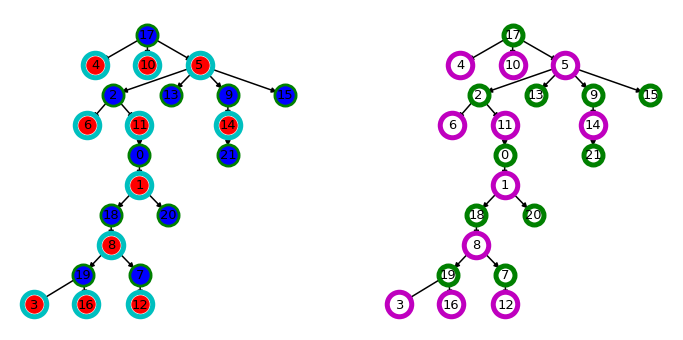

In [46]:
plot_encoding_tree(t, dfs_order)

In [47]:
print(' '.join(map(str, dfs_order)))

17 4 10 5 2 6 11 0 1 18 8 19 3 16 7 12 20 13 9 14 21 15


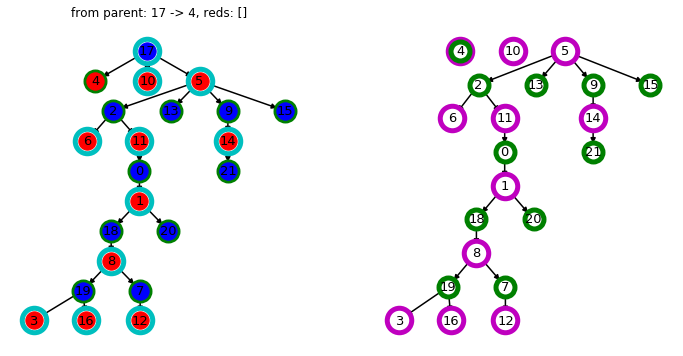

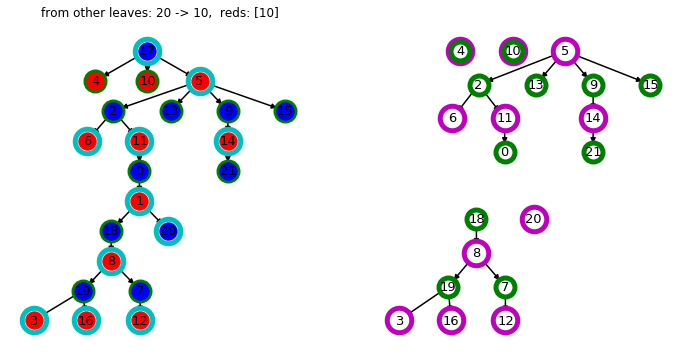

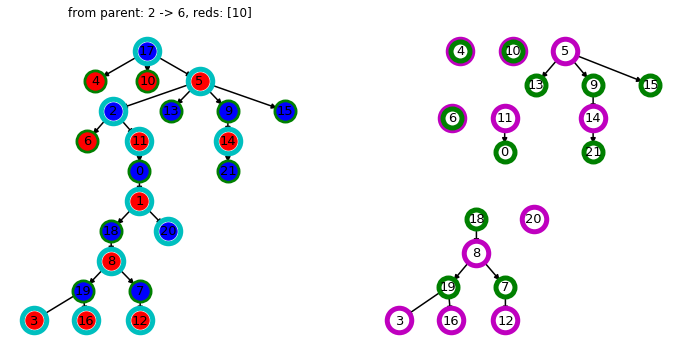

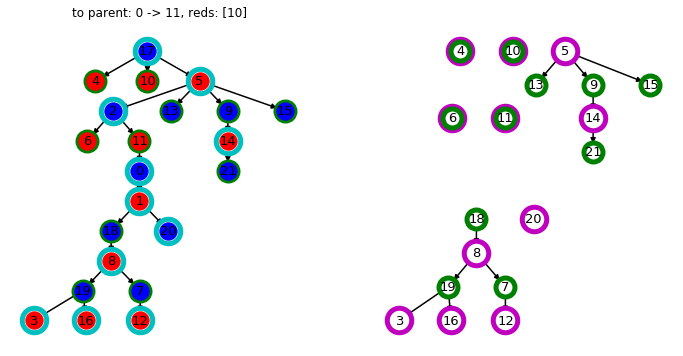

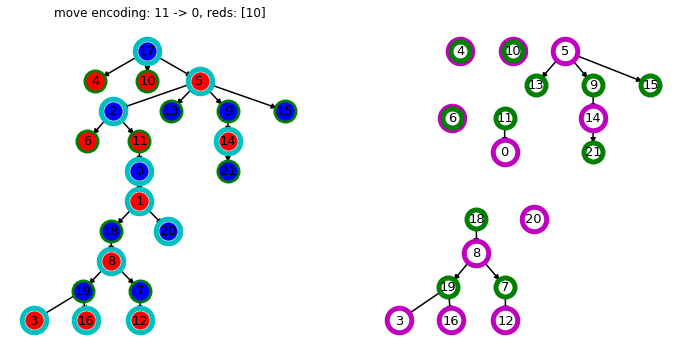

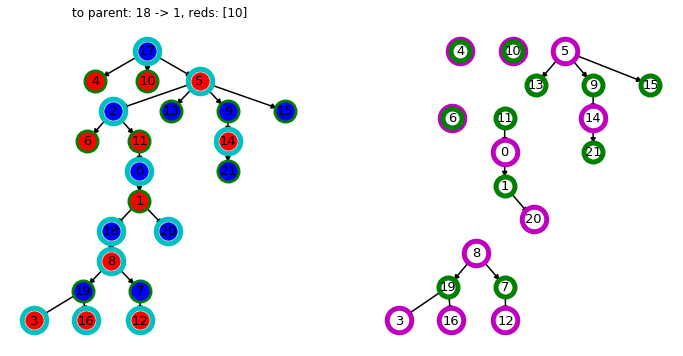

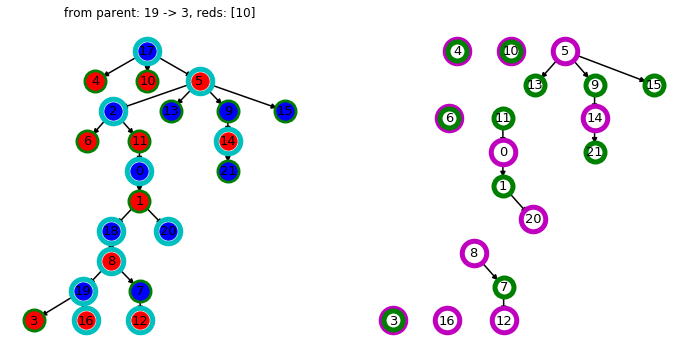

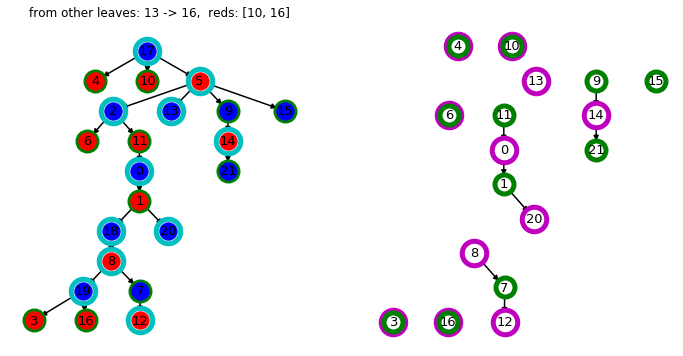

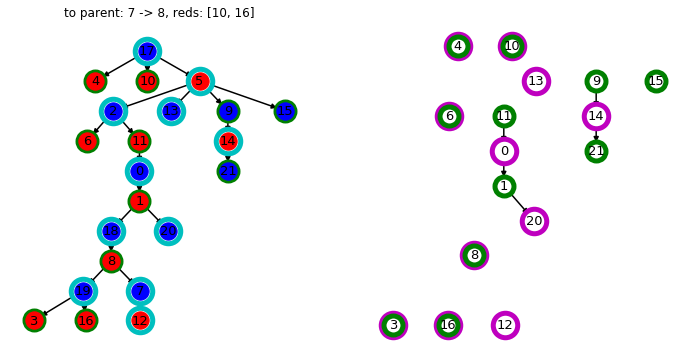

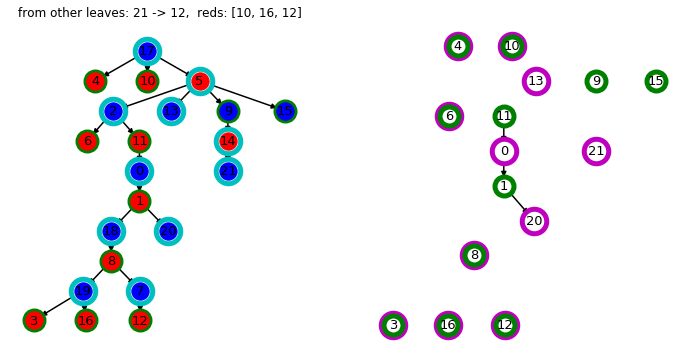

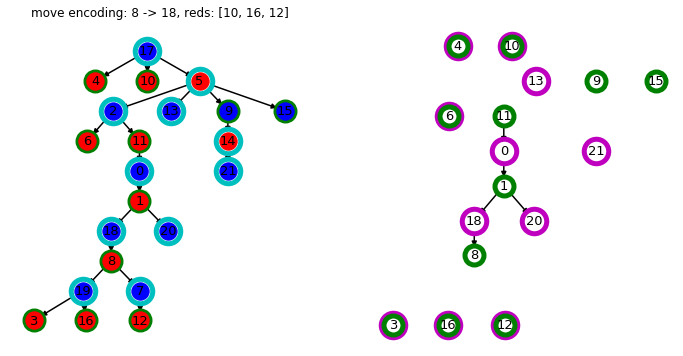

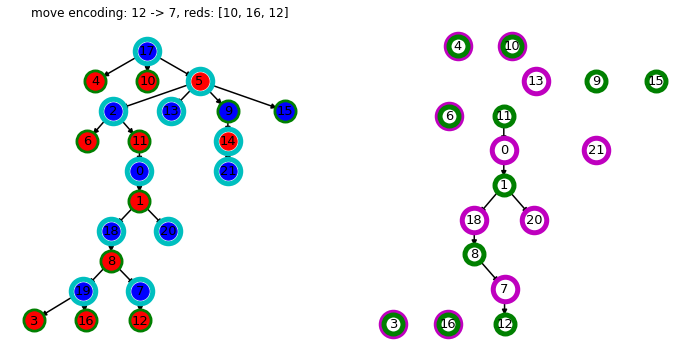

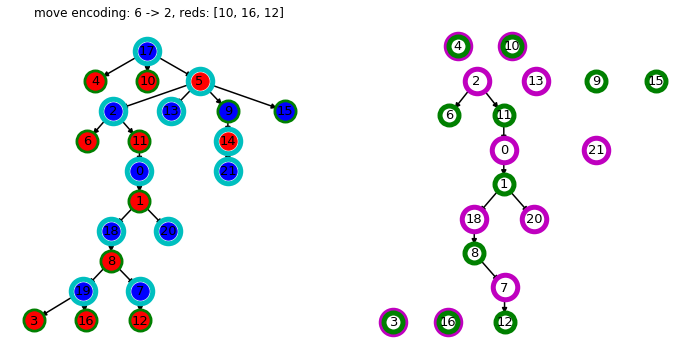

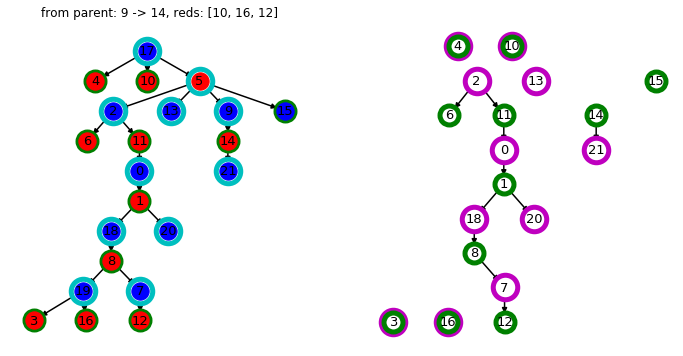

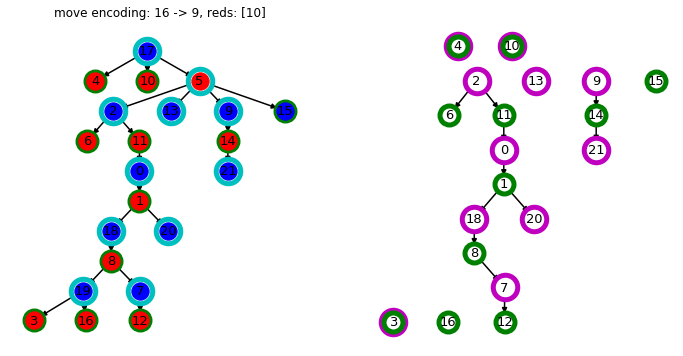

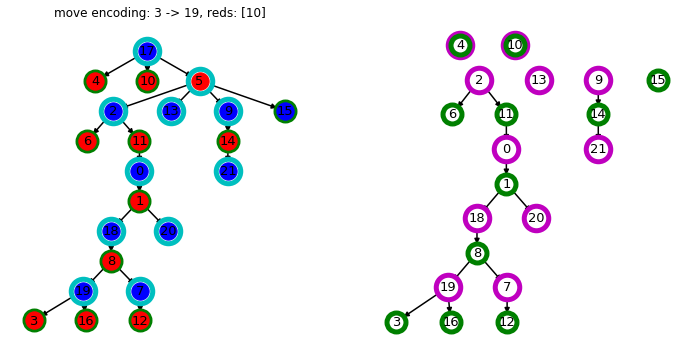

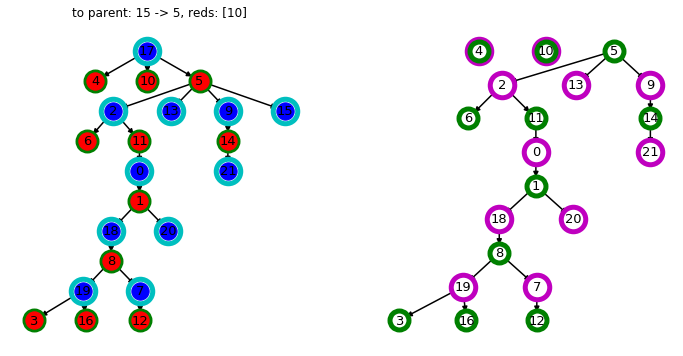

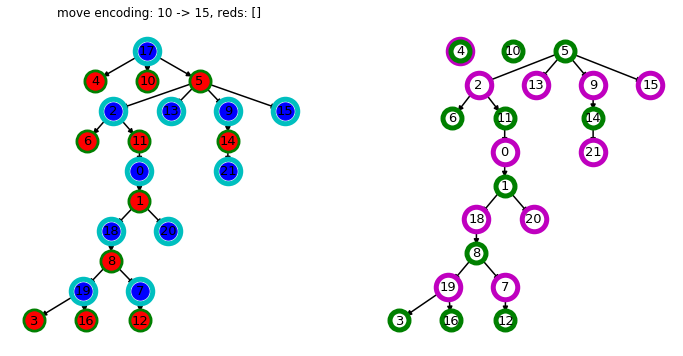

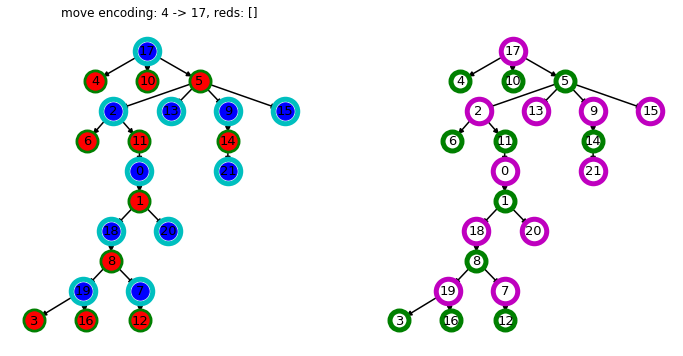

In [48]:
ct = nx.DiGraph(t)
to_borrow_2, pre_reds_2 = list(to_borrow), list(pre_reds)
process(ct, root, to_borrow_2, pre_reds_2)

In [26]:
print_dfs_tree(t, root)

NameError: name 'print_dfs_tree' is not defined

In [ ]:
### order is a very important problem